In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)


In [3]:
DATA_PATH = "/Users/samiaibrahim/fintech-credit-decisioning/data/loan50.csv"  # <-- change if needed

df = pd.read_csv(DATA_PATH)

print("shape:", df.shape)
display(df.head(3))
display(df.sample(3, random_state=42))

display(df.dtypes.to_frame("dtype").sort_values("dtype"))

shape: (50, 18)


,state,emp_length,term,homeownership,annual_income,verified_income,debt_to_income,total_credit_limit,total_credit_utilized,num_cc_carrying_balance,loan_purpose,loan_amount,grade,interest_rate,public_record_bankrupt,loan_status,has_second_income,total_income
0,NJ,3.0,60,rent,59000,Not Verified,0.557525,95131,32894,8,debt_consolidation,22000,B,10.90,0,Current,False,59000
1,CA,10.0,36,rent,60000,Not Verified,1.305683,51929,78341,2,credit_card,6000,B,9.92,1,Current,False,60000
2,SC,NaN,36,mortgage,75000,Verified,1.056280,301373,79221,14,debt_consolidation,25000,E,26.30,0,Current,False,75000


,state,emp_length,term,homeownership,annual_income,verified_income,debt_to_income,total_credit_limit,total_credit_utilized,num_cc_carrying_balance,loan_purpose,loan_amount,grade,interest_rate,public_record_bankrupt,loan_status,has_second_income,total_income
13,NE,2.0,36,mortgage,105000,Not Verified,0.268190,279386,28160,2,home_improvement,16500,A,5.31,0,Current,False,105000
39,MD,3.0,36,rent,70000,Source Verified,5.333729,272878,373361,2,other,7500,A,7.34,0,Current,False,70000
30,VA,0.0,36,rent,116000,Source Verified,0.584397,446850,67790,7,debt_consolidation,13125,B,10.91,0,Current,False,116000


,dtype
has_second_income,bool
total_credit_utilized,int64
public_record_bankrupt,int64
loan_amount,int64
num_cc_carrying_balance,int64
total_credit_limit,int64
total_income,int64
annual_income,int64
term,int64
interest_rate,float64


In [4]:
#data quality check
missing = (df.isna().mean().sort_values(ascending=False) * 100).to_frame("% missing")
display(missing.head(40))

dupes = df.duplicated().sum()
print("duplicate rows:", dupes)

display(df.describe(include="number").T)


,% missing
emp_length,4.0
state,0.0
has_second_income,0.0
loan_status,0.0
public_record_bankrupt,0.0
interest_rate,0.0
grade,0.0
loan_amount,0.0
loan_purpose,0.0
num_cc_carrying_balance,0.0


duplicate rows: 0


,count,mean,std,min,25%,50%,75%,max
emp_length,48.0,4.895833,3.520394,0.000000,2.000000,5.000000,8.250000,10.000000
term,50.0,42.720000,10.885377,36.000000,36.000000,36.000000,60.000000,60.000000
annual_income,50.0,86170.000000,57566.498371,28800.000000,55750.000000,74000.000000,99500.000000,325000.000000
debt_to_income,50.0,0.722643,0.958264,0.054724,0.266424,0.540471,0.741217,5.333729
total_credit_limit,50.0,208546.640000,167514.864327,15980.000000,70526.250000,147363.500000,299766.250000,793009.000000
total_credit_utilized,50.0,61546.540000,63778.074324,2872.000000,25693.500000,48005.500000,76796.250000,373361.000000
num_cc_carrying_balance,50.0,5.060000,2.999388,1.000000,3.000000,4.000000,6.000000,14.000000
loan_amount,50.0,17083.000000,10455.456343,3000.000000,7125.000000,15500.000000,24000.000000,40000.000000
interest_rate,50.0,11.567200,5.052115,5.310000,7.960000,9.930000,13.715000,26.300000
public_record_bankrupt,50.0,0.080000,0.274048,0.000000,0.000000,0.000000,0.000000,1.000000


In [7]:
df_eda = df.copy()

#target
default_statuses = {
    "Charged Off",
    "Default",
    "Late (31-120 days)"
}

df_eda["default_flag"] = df_eda["loan_status"].isin(default_statuses).astype(int)

#date-ish
if "issue_month" in df_eda.columns:
    df_eda["issue_month"] = pd.to_datetime(df_eda["issue_month"], errors="coerce")

if "earliest_credit_line" in df_eda.columns:
    df_eda["earliest_credit_line"] = pd.to_datetime(df_eda["earliest_credit_line"], errors="coerce")

#numeric coercions (safe)
numeric_candidates = [
    "annual_income","annual_income_joint",
    "debt_to_income","debt_to_income_joint",
    "loan_amount","interest_rate","installment",
    "total_credit_limit","total_credit_utilized","total_debit_limit",
    "delinq_2y","inquiries_last_12m","total_credit_lines","open_credit_lines",
    "num_collections_last_12m","num_historical_failed_to_pay",
    "months_since_last_delinq","months_since_90d_late","months_since_last_credit_inquiry",
    "current_accounts_delinq","total_collection_amount_ever",
    "current_installment_accounts","accounts_opened_24m","num_satisfactory_accounts",
    "num_accounts_120d_past_due","num_accounts_30d_past_due",
    "num_active_debit_accounts","num_total_cc_accounts","num_open_cc_accounts",
    "num_cc_carrying_balance","num_mort_accounts","account_never_delinq_percent",
    "tax_liens","public_record_bankrupt",
    "balance","paid_total","paid_principal","paid_interest","paid_late_fees"
]
for c in numeric_candidates:
    if c in df_eda.columns:
        df_eda[c] = pd.to_numeric(df_eda[c], errors="coerce")

#clean common categoricals
cat_candidates = [
    "state","homeownership","verified_income","verification_income_joint",
    "loan_purpose","application_type","term","grade","sub_grade",
    "loan_status","initial_listing_status","disbursement_method","emp_length","emp_title"
]
for c in cat_candidates:
    if c in df_eda.columns:
        df_eda[c] = df_eda[c].astype("string").str.strip()

default_flag
<NA>    50
Name: count, dtype: Int64
default rate (non-missing): <NA>


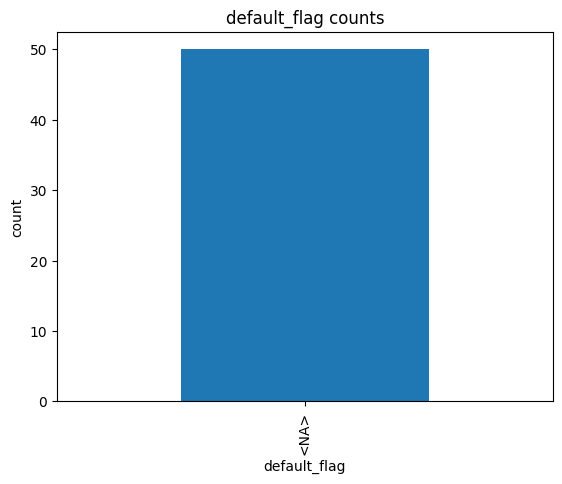

In [11]:
#target distribution
df_eda["default_flag"] = pd.to_numeric(df_eda["loan_status"], errors="coerce")

print(df_eda["default_flag"].value_counts(dropna=False))
print("default rate (non-missing):", df_eda["default_flag"].mean())

ax = df_eda["default_flag"].value_counts(dropna=False).plot(kind="bar")
ax.set_title("default_flag counts")
ax.set_xlabel("default_flag")
ax.set_ylabel("count")
plt.show()


In [13]:
#date parsing + credit history feature flag, fixes Unit M error
def parse_month_year(s: pd.Series) -> pd.Series:
    s = s.astype("string")
    out = pd.to_datetime(s, errors="coerce")
    if out.isna().mean() > 0.2:
        out2 = pd.to_datetime(s, format="%b-%Y", errors="coerce")
        out = out.fillna(out2)
    return out.dt.to_period("M").dt.to_timestamp()

def month_diff(later: pd.Series, earlier: pd.Series) -> pd.Series:
    later_p = later.dt.to_period("M")
    earlier_p = earlier.dt.to_period("M")
    return (later_p.dt.year - earlier_p.dt.year) * 12 + (later_p.dt.month - earlier_p.dt.month)

df_eda["issue_dt"] = parse_month_year(df_eda["issue_month"])
df_eda["earliest_credit_dt"] = parse_month_year(df_eda["earliest_credit_line"])
df_eda["credit_history_months"] = month_diff(df_eda["issue_dt"], df_eda["earliest_credit_dt"])
df_eda.loc[df_eda["credit_history_months"] < 0, "credit_history_months"] = np.nan

display(df_eda[["issue_dt", "issue_dt", "earliest_credit_line", "earliest_credit_dt", "credit_history_months"]].head(10))


KeyError: 'issue_month'

In [14]:
#joint vs individual effective income + DTI
#Normalize application_type strings if needed
df_eda["application_type"] = df_eda["application_type"].astype("string").str.lower()

is_joint = df_eda["application_type"].str.contains("joint", na=False)

df_eda["income_effective"] = df_eda["annual_income"]
df_eda.loc[is_joint & df_eda["annual_income_joint"].notna(), "income_effective"] = df_eda.loc[is_joint, "annual_income_joint"]

df_eda["dti_effective"] = df_eda["debt_to_income"]
df_eda.loc[is_joint & df_eda["debt_to_income_joint"].notna(), "dti_effective"] = df_eda.loc[is_joint, "debt_to_income_joint"]

display(df_eda[["application_type","annual_income","annual_income_joint","income_effective","debt_to_income","debt_to_income_joint","dti_effective"]].head(10))


KeyError: 'application_type'

In [ ]:
expected_ident = {"user_id","name","dob","ssn_pattern","address","fraud_label"}
expected_email = {"user_id","email_age_days","phone_carrier","disposable_email_flag"}
expected_device = {"user_id","device_id","ip_address","geo_location","event_timestamp"}

assert expected_ident.issubset(set(ident.columns))
assert expected_email.issubset(set(email_phone.columns))
assert expected_device.issubset(set(device.columns))

In [ ]:
def null_report(df, name):
    out = df.isna().mean().sort_values(ascending=False).head(20)
    print(f"{name} null rate (top 20):")
    display(out)

null_report(ident, "ident")
null_report(email_phone, "email_phone")
null_report(device, "device")

print("Unique users:", ident["user_id"].nunique(), email_phone["user_id"].nunique(), device["user_id"].nunique())

In [ ]:
ident["fraud_label"].value_counts(dropna=False).sort_index()

In [ ]:
df = ident.merge(email_phone, on="user_id", how="left", validate="one_to_one")

device_user_counts = device.groupby("user_id").size().rename("device_event_count").reset_index()
df = df.merge(device_user_counts, on="user_id", how="left")

df["device_event_count"] = df["device_event_count"].fillna(0)

df[["user_id","fraud_label","email_age_days","disposable_email_flag","device_event_count"]].head(10)

In [ ]:
#check missingness rates by fraud label important for bias/leakage
df.groupby("fraud_label")[["email_age_days","disposable_email_flag","device_event_count"]].apply(lambda x: x.isna().mean())

In [ ]:
#sace ckean audit join snapshot
df.to_csv("data/processed/join_audit_snapshot.csv", index=False)